In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pip install layout_prompter

# General configurations

In [4]:
from layout_prompter.dataset_configs import PosterLayoutDatasetConfig


dataset_config = PosterLayoutDatasetConfig()
task = "content"
input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = True
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 10

# Load raw data

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Process raw data

In [21]:
import os
import pandas as pd

from tqdm import tqdm
from layout_prompter.preprocessors import create_processor
from layout_prompter.utils import get_raw_data_path, read_pt, write_pt


metadata = pd.read_csv("/content/drive/My Drive/LayoutPrompter/posterlayout/raw_small/train_csv_9973.csv")
processor = create_processor(dataset_config, task, metadata=metadata)
# base_dir = os.path.dirname(os.getcwd())
base_dir = "/content/drive/My Drive/LayoutPrompter/posterlayout"



def get_processed_dataset(split):
    print("split", split)
    filename = os.path.join(
        base_dir, "dataset", dataset_config.name, "processed", task, f"{split}.pt"
    )
    print("filename", filename)
    if os.path.exists(filename):
        processed_data = read_pt(filename)
    else:
        processed_data = []
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        raw_path = os.path.join(base_dir, "raw_small", split, "saliencymaps_pfpn")
        raw_data = os.listdir(raw_path)
        raw_data = sorted(raw_data, key=lambda x: int(x.split("_")[0]))
        for rd in tqdm(raw_data, desc=f"{split} data processing..."):
            idx = int(rd.split("_")[0])
            data = processor(os.path.join(raw_path, rd), idx, split)
            if data:
                processed_data.append(data)
        write_pt(filename, processed_data)
    return processed_data


processed_train_dataset = get_processed_dataset("train")
processed_test_dataset = get_processed_dataset("test")

split train
filename /content/drive/My Drive/LayoutPrompter/posterlayout/dataset/posterlayout/processed/content/train.pt
split test
filename /content/drive/My Drive/LayoutPrompter/posterlayout/dataset/posterlayout/processed/content/test.pt


/usr/local/lib/python3.10/dist-packages/layout_prompter/utils.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f)


# Get target test data

In [20]:
test_idx = 0
test_data = processed_test_dataset[test_idx]

# Define dynamic exemplar selection

In [9]:
from layout_prompter.modules import create_selector


selector = create_selector(
    task=task,
    train_dataset=processed_train_dataset,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
    dataset_config=dataset_config,
)

# Define input-output serialization

In [10]:
from layout_prompter.modules import create_serializer


serializer = create_serializer(
    dataset_config=dataset_config,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token,
)

# Define GPT callar

In [13]:
from layout_prompter.parsers import GPTResponseParser
from layout_prompter.modules import GPTCallar

model = "gpt-4o"
max_tokens = 800
temperature = 0.7
top_p = 1
frequency_penalty = 0.0
presence_penalty = 0.0
num_return = 10
stop_token = "\n\n"

assert os.environ.get("OPENAI_API_KEY") is not None

parser = GPTResponseParser(
    dataset_config=dataset_config,
    output_format=output_format
)

llm = GPTCallar(
    parser=parser,
    model=model,
    max_tokens=max_tokens,
    temperature=temperature,
    top_p=top_p,
    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty,
    num_return=num_return,
    stop_token=stop_token
)

# Define Ranker

In [14]:
from layout_prompter.modules import Ranker


ranker = Ranker()

# Define LayoutPrompter pipeline

In [15]:
from layout_prompter import LayoutPrompter


pipeline = LayoutPrompter(
    serializer=serializer,
    selector=selector,
    llm=llm,
    ranker=ranker,
)

# Generate layouts

In [19]:
exemplars = pipeline.get_exemplars(test_data=test_data)

# (1) Build prompt based on the exemplars
# (2) Generate layouts using LLM
# (3) Re-rank the generated results
ranked_response = pipeline(
    test_data=test_data, exemplars=exemplars
)
# print(ranked_response)

ERROR:layout_prompter.layout_prompter:not enough values to unpack (expected 4, got 0)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/layout_prompter/layout_prompter.py", line 43, in _generate_layout
    return self.ranker(response)
  File "/usr/local/lib/python3.10/dist-packages/layout_prompter/modules/rankers.py", line 65, in __call__
    _pred_bboxes = convert_ltwh_to_ltrb(pred_bboxes).unsqueeze(0)
  File "/usr/local/lib/python3.10/dist-packages/layout_prompter/utils.py", line 51, in convert_ltwh_to_ltrb
    left, top, width, height = bbox
ValueError: not enough values to unpack (expected 4, got 0)
ERROR:layout_prompter.layout_prompter:not enough values to unpack (expected 4, got 0)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/layout_prompter/layout_prompter.py", line 43, in _generate_layout
    return self.ranker(response)
  File "/usr/local/lib/python3.10/dist-packages/layout_prompter/modules/rankers.py", lin

LayoutPrompterException: Failed to generate layout for prompt: [{'role': 'system', 'content': 'Please generate a layout based on the given information. You need to ensure that the generated layout looks realistic, with elements well aligned and avoiding unnecessary overlap.\nTask Description: content-aware layout generation\nPlease place the following elements to avoid salient content, and underlay must be the background of text or logo.\nLayout Domain: poster layout\nCanvas Size: canvas width is 102px, canvas height is 150px'}, {'role': 'user', 'content': 'Content Constraint: left 26px, top 59px, width 50px, height 90px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | underlay 4\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 32px; top: 0px; width: 35px; height: 8px"></div>\n<div class="text" style="index: 1; left: 34px; top: 16px; width: 32px; height: 5px"></div>\n<div class="text" style="index: 2; left: 9px; top: 25px; width: 82px; height: 13px"></div>\n<div class="text" style="index: 3; left: 32px; top: 45px; width: 36px; height: 4px"></div>\n<div class="underlay" style="index: 4; left: 23px; top: 43px; width: 55px; height: 8px"></div>\n</body>\n</html>\n\nContent Constraint: left 27px, top 71px, width 49px, height 54px\nElement Type Constraint: logo 0 | text 1 | text 2 | underlay 3\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 24px; top: 20px; width: 46px; height: 11px"></div>\n<div class="text" style="index: 1; left: 14px; top: 36px; width: 73px; height: 11px"></div>\n<div class="text" style="index: 2; left: 33px; top: 57px; width: 33px; height: 3px"></div>\n<div class="underlay" style="index: 3; left: 31px; top: 54px; width: 38px; height: 8px"></div>\n</body>\n</html>\n\nContent Constraint: left 26px, top 62px, width 49px, height 69px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | text 4 | underlay 5\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 3px; top: 3px; width: 21px; height: 6px"></div>\n<div class="text" style="index: 1; left: 24px; top: 14px; width: 51px; height: 7px"></div>\n<div class="text" style="index: 2; left: 6px; top: 26px; width: 88px; height: 7px"></div>\n<div class="text" style="index: 3; left: 19px; top: 38px; width: 63px; height: 5px"></div>\n<div class="text" style="index: 4; left: 22px; top: 49px; width: 57px; height: 5px"></div>\n<div class="underlay" style="index: 5; left: 18px; top: 48px; width: 64px; height: 9px"></div>\n</body>\n</html>\n\nContent Constraint: left 34px, top 56px, width 34px, height 73px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | underlay 4\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 33px; top: 7px; width: 35px; height: 13px"></div>\n<div class="text" style="index: 1; left: 15px; top: 24px; width: 71px; height: 8px"></div>\n<div class="text" style="index: 2; left: 6px; top: 37px; width: 90px; height: 9px"></div>\n<div class="text" style="index: 3; left: 18px; top: 62px; width: 18px; height: 14px"></div>\n<div class="underlay" style="index: 4; left: 14px; top: 55px; width: 27px; height: 27px"></div>\n</body>\n</html>\n\nContent Constraint: left 23px, top 57px, width 53px, height 65px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | underlay 4 | underlay 5\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 37px; top: 10px; width: 27px; height: 9px"></div>\n<div class="text" style="index: 1; left: 22px; top: 26px; width: 58px; height: 14px"></div>\n<div class="text" style="index: 2; left: 26px; top: 46px; width: 47px; height: 5px"></div>\n<div class="text" style="index: 3; left: 45px; top: 130px; width: 21px; height: 6px"></div>\n<div class="underlay" style="index: 4; left: 23px; top: 44px; width: 53px; height: 9px"></div>\n<div class="underlay" style="index: 5; left: 29px; top: 128px; width: 43px; height: 10px"></div>\n</body>\n</html>\n\nContent Constraint: left 23px, top 60px, width 55px, height 83px\nElement Type Constraint: logo 0 | text 1 | underlay 2\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 32px; top: 8px; width: 37px; height: 24px"></div>\n<div class="text" style="index: 1; left: 27px; top: 42px; width: 47px; height: 5px"></div>\n<div class="underlay" style="index: 2; left: 26px; top: 38px; width: 52px; height: 12px"></div>\n</body>\n</html>\n\nContent Constraint: left 21px, top 63px, width 58px, height 79px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | text 4 | underlay 5\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 24px; top: 7px; width: 53px; height: 9px"></div>\n<div class="text" style="index: 1; left: 2px; top: 20px; width: 95px; height: 6px"></div>\n<div class="text" style="index: 2; left: 20px; top: 34px; width: 35px; height: 9px"></div>\n<div class="text" style="index: 3; left: 61px; top: 36px; width: 17px; height: 6px"></div>\n<div class="text" style="index: 4; left: 20px; top: 47px; width: 45px; height: 10px"></div>\n<div class="underlay" style="index: 5; left: 58px; top: 36px; width: 23px; height: 6px"></div>\n</body>\n</html>\n\nContent Constraint: left 17px, top 53px, width 66px, height 79px | left 23px, top 113px, width 13px, height 21px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | text 4 | underlay 5 | underlay 6 | underlay 7\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 4px; top: 5px; width: 27px; height: 6px"></div>\n<div class="text" style="index: 1; left: 9px; top: 20px; width: 81px; height: 9px"></div>\n<div class="text" style="index: 2; left: 42px; top: 34px; width: 16px; height: 4px"></div>\n<div class="text" style="index: 3; left: 16px; top: 34px; width: 16px; height: 3px"></div>\n<div class="text" style="index: 4; left: 68px; top: 34px; width: 16px; height: 3px"></div>\n<div class="underlay" style="index: 5; left: 13px; top: 33px; width: 22px; height: 6px"></div>\n<div class="underlay" style="index: 6; left: 39px; top: 33px; width: 22px; height: 6px"></div>\n<div class="underlay" style="index: 7; left: 65px; top: 33px; width: 22px; height: 6px"></div>\n</body>\n</html>\n\nContent Constraint: left 29px, top 56px, width 41px, height 84px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | text 4 | underlay 5\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 38px; top: 8px; width: 24px; height: 5px"></div>\n<div class="text" style="index: 1; left: 7px; top: 16px; width: 85px; height: 8px"></div>\n<div class="text" style="index: 2; left: 35px; top: 29px; width: 33px; height: 4px"></div>\n<div class="text" style="index: 3; left: 14px; top: 58px; width: 10px; height: 4px"></div>\n<div class="text" style="index: 4; left: 14px; top: 63px; width: 16px; height: 4px"></div>\n<div class="underlay" style="index: 5; left: 13px; top: 56px; width: 19px; height: 13px"></div>\n</body>\n</html>\n\nContent Constraint: left 17px, top 57px, width 71px, height 83px\nElement Type Constraint: logo 0 | text 1 | text 2 | text 3 | text 4 | underlay 5\n<html>\n<body>\n<div class="canvas" style="left: 0px; top: 0px; width: 102px; height: 150px"></div>\n<div class="logo" style="index: 0; left: 3px; top: 5px; width: 26px; height: 9px"></div>\n<div class="text" style="index: 1; left: 5px; top: 15px; width: 64px; height: 11px"></div>\n<div class="text" style="index: 2; left: 5px; top: 27px; width: 46px; height: 6px"></div>\n<div class="text" style="index: 3; left: 7px; top: 39px; width: 64px; height: 5px"></div>\n<div class="text" style="index: 4; left: 4px; top: 47px; width: 43px; height: 3px"></div>\n<div class="underlay" style="index: 5; left: 5px; top: 38px; width: 69px; height: 8px"></div>\n</body>\n</html>\n\nContent Constraint: left 26px, top 58px, width 51px, height 73px\nElement Type Constraint: text 0 | text 1 | underlay 2 | underlay 3\n'}]

# Visualize the layouts

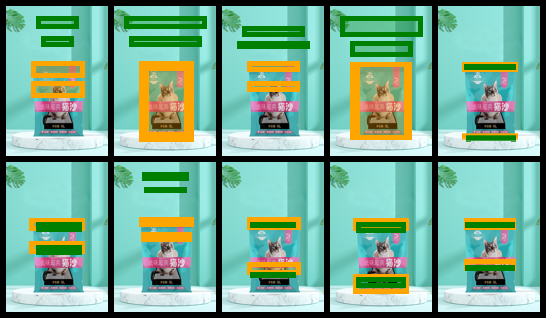

In [ ]:
from layout_prompter.visualizers import ContentAwareVisualizer, create_image_grid


canvas_path = os.path.join(base_dir, "raw_small", "test", "image_canvas")
visualizer = ContentAwareVisualizer(dataset_config=dataset_config, canvas_path=canvas_path)
images = visualizer(ranked_response, test_idx=test_idx)

create_image_grid(images)